<a href="https://colab.research.google.com/github/savitakumbhare/Employee-Attrition-0.1/blob/master/Traffic_prediction_using_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
for dirname, _, filenames in os.walk('/content/sample_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/distance.csv
/content/sample_data/PEMS04.npz
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv


In [2]:
import csv
import torch
import numpy as np
from torch.utils.data import Dataset


def get_adjacent_matrix(distance_file: str, num_nodes: int, id_file: str = None, graph_type="connect") -> np.array:
    """
    :param distance_file: str, path of csv file to save the distances between nodes.
    :param num_nodes: int, number of nodes in the graph
    :param id_file: str, path of txt file to save the order of the nodes.
    :param graph_type: str, ["connect", "distance"]
    :return:
        np.array(N, N)
    """
    A = np.zeros([int(num_nodes), int(num_nodes)])

    if id_file:
        with open(id_file, "r") as f_id:
            node_id_dict = {int(node_id): idx for idx, node_id in enumerate(f_id.read().strip().split("\n"))}

            with open(distance_file, "r") as f_d:
                f_d.readline()
                reader = csv.reader(f_d)
                for item in reader:
                    if len(item) != 3:
                        continue
                    i, j, distance = int(item[0]), int(item[1]), float(item[2])
                    if graph_type == "connect":
                        A[node_id_dict[i], node_id_dict[j]] = 1.
                        A[node_id_dict[j], node_id_dict[i]] = 1.
                    elif graph_type == "distance":
                        A[node_id_dict[i], node_id_dict[j]] = 1. / distance
                        A[node_id_dict[j], node_id_dict[i]] = 1. / distance
                    else:
                        raise ValueError("graph type is not correct (connect or distance)")
        return A

    with open(distance_file, "r") as f_d:
        f_d.readline()
        reader = csv.reader(f_d)
        for item in reader:
            if len(item) != 3:
                continue
            i, j, distance = int(item[0]), int(item[1]), float(item[2])

            if graph_type == "connect":
                A[i, j], A[j, i] = 1., 1.
            elif graph_type == "distance":
                A[i, j] = 1. / distance
                A[j, i] = 1. / distance
            else:
                raise ValueError("graph type is not correct (connect or distance)")

    return A


def get_flow_data(flow_file: str) -> np.array:
    """
    :param flow_file: str, path of .npz file to save the traffic flow data
    :return:
        np.array(N, T, D)
    """
    data = np.load(flow_file)

    flow_data = data['data'].transpose([1, 0, 2])[:, :, 0][:, :, np.newaxis]

    return flow_data


class LoadData(Dataset):
    def __init__(self, data_path, num_nodes, divide_days, time_interval, history_length, train_mode):
        """
        :param data_path: list, ["graph file name" , "flow data file name"], path to save the data file names.
        :param num_nodes: int, number of nodes.
        :param divide_days: list, [ days of train data, days of test data], list to divide the original data.
        :param time_interval: int, time interval between two traffic data records (mins).
        :param history_length: int, length of history data to be used.
        :param train_mode: list, ["train", "test"].
        """

        self.data_path = data_path
        self.num_nodes = num_nodes
        self.train_mode = train_mode
        self.train_days = divide_days[0]  # 45
        self.test_days = divide_days[1]  # 14
        self.history_length = history_length  # 6
        self.time_interval = time_interval  # 5 min

        self.one_day_length = int(24 * 60 / self.time_interval)

        self.graph = get_adjacent_matrix(distance_file=data_path[0], num_nodes=num_nodes)

        self.flow_norm, self.flow_data = self.pre_process_data(data=get_flow_data(data_path[1]), norm_dim=1)

    def __len__(self):
        """
        :return: length of dataset (number of samples).
        """
        if self.train_mode == "train":
            return self.train_days * self.one_day_length - self.history_length
        elif self.train_mode == "test":
            return self.test_days * self.one_day_length
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

    def __getitem__(self, index):  # (x, y), index = [0, L1 - 1]
        """
        :param index: int, range between [0, length - 1].
        :return:
            graph: torch.tensor, [N, N].
            data_x: torch.tensor, [N, H, D].
            data_y: torch.tensor, [N, 1, D].
        """
        if self.train_mode == "train":
            index = index
        elif self.train_mode == "test":
            index += self.train_days * self.one_day_length
        else:
            raise ValueError("train mode: [{}] is not defined".format(self.train_mode))

        data_x, data_y = LoadData.slice_data(self.flow_data, self.history_length, index, self.train_mode)

        data_x = LoadData.to_tensor(data_x)  # [N, H, D]
        data_y = LoadData.to_tensor(data_y).unsqueeze(1)  # [N, 1, D]

        return {"graph": LoadData.to_tensor(self.graph), "flow_x": data_x, "flow_y": data_y}

    @staticmethod
    def slice_data(data, history_length, index, train_mode):
        """
        :param data: np.array, normalized traffic data.
        :param history_length: int, length of history data to be used.
        :param index: int, index on temporal axis.
        :param train_mode: str, ["train", "test"].
        :return:
            data_x: np.array, [N, H, D].
            data_y: np.array [N, D].
        """
        if train_mode == "train":
            start_index = index
            end_index = index + history_length
        elif train_mode == "test":
            start_index = index - history_length
            end_index = index
        else:
            raise ValueError("train model {} is not defined".format(train_mode))

        data_x = data[:, start_index: end_index]
        data_y = data[:, end_index]

        return data_x, data_y

    @staticmethod
    def pre_process_data(data, norm_dim):
        """
        :param data: np.array, original traffic data without normalization.
        :param norm_dim: int, normalization dimension.
        :return:
            norm_base: list, [max_data, min_data], data of normalization base.
            norm_data: np.array, normalized traffic data.
        """
        norm_base = LoadData.normalize_base(data, norm_dim)  # find the normalize base
        norm_data = LoadData.normalize_data(norm_base[0], norm_base[1], data)  # normalize data

        return norm_base, norm_data

    @staticmethod
    def normalize_base(data, norm_dim):
        """
        :param data: np.array, original traffic data without normalization.
        :param norm_dim: int, normalization dimension.
        :return:
            max_data: np.array
            min_data: np.array
        """
        max_data = np.max(data, norm_dim, keepdims=True)  # [N, T, D] , norm_dim=1, [N, 1, D]
        min_data = np.min(data, norm_dim, keepdims=True)
        return max_data, min_data

    @staticmethod
    def normalize_data(max_data, min_data, data):
        """
        :param max_data: np.array, max data.
        :param min_data: np.array, min data.
        :param data: np.array, original traffic data without normalization.
        :return:
            np.array, normalized traffic data.
        """
        mid = min_data
        base = max_data - min_data
        normalized_data = (data - mid) / base

        return normalized_data

    @staticmethod
    def recover_data(max_data, min_data, data):
        """
        :param max_data: np.array, max data.
        :param min_data: np.array, min data.
        :param data: np.array, normalized data.
        :return:
            recovered_data: np.array, recovered data.
        """
        mid = min_data
        base = max_data - min_data

        recovered_data = data * base + mid

        return recovered_data

    @staticmethod
    def to_tensor(data):
        return torch.tensor(data, dtype=torch.float)


if __name__ == '__main__':
    train_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    print(len(train_data))
    print(train_data[0]["flow_x"].size())
    print(train_data[0]["flow_y"].size())

12954
torch.Size([307, 6, 1])
torch.Size([307, 1, 1])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphAttentionLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super(GraphAttentionLayer, self).__init__()
        self.in_c = in_c
        self.out_c = out_c

        self.F = F.softmax

        self.W = nn.Linear(in_c, out_c, bias=False)  # y = W * x
        self.b = nn.Parameter(torch.Tensor(out_c))

        nn.init.normal_(self.W.weight)
        nn.init.normal_(self.b)

    def forward(self, inputs, graph):
        """
        :param inputs: input features, [B, N, C].
        :param graph: graph structure, [N, N].
        :return:
            output features, [B, N, D].
        """

        h = self.W(inputs)  # [B, N, D]
        outputs = torch.bmm(h, h.transpose(1, 2)) * graph.unsqueeze(0)  # [B, N, D]*[B, D, N]->[B, N, N]      x(i)^T * x(j)

        outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))

        attention = self.F(outputs, dim=2)   # [B, N, N]
        return torch.bmm(attention, h) + self.b  # [B, N, N] * [B, N, D]


class GATSubNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATSubNet, self).__init__()

        self.attention_module = nn.ModuleList([GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)])
        self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)

        self.act = nn.LeakyReLU()

    def forward(self, inputs, graph):
        """
        :param inputs: [B, N, C]
        :param graph: [N, N]
        :return:
        """
        outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)  # [B, N, hid_c * h_head]
        outputs = self.act(outputs)

        outputs = self.out_att(outputs, graph)

        return self.act(outputs)


class GATNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATNet, self).__init__()
        self.subnet = GATSubNet(in_c, hid_c, out_c, n_heads)
        # self.subnet = [GATSubNet(...) for _ in range(T)]

    def forward(self, data, device):
        graph = data["graph"][0].to(device)  # [N, N]
        flow = data["flow_x"]  # [B, N, T, C]
        flow = flow.to(device)

        B, N = flow.size(0), flow.size(1)
        flow = flow.view(B, N, -1)  # [B, N, T * C]

        prediction = self.subnet(flow, graph).unsqueeze(2)  # [B, N, 1, C]

        return prediction


if __name__ == '__main__':
    x = torch.randn(32, 278, 6, 2)  # [B, N, T, C]
    graph = torch.randn(32, 278, 278)  # [N, N]
    data = {"flow_x": x, "graph": graph}

    device = torch.device("cpu")

    net = GATNet(in_c=6 * 2, hid_c=6, out_c=2, n_heads=2)

    y = net(data, device)
    print(y.size())

torch.Size([32, 278, 1, 2])


In [4]:
import h5py


class Evaluation(object):
    def __init__(self):
        pass

    @staticmethod
    def mae_(target, output):
        return np.mean(np.abs(target - output))

    @staticmethod
    def mape_(target, output):
        return np.mean(np.abs(target - output) / (target + 0.5))

    @staticmethod
    def rmse_(target, output):
        return np.sqrt(np.mean(np.power(target - output, 2)))

    @staticmethod
    def total(target, output):
        mae = Evaluation.mae_(target, output)
        mape = Evaluation.mape_(target, output)
        rmse = Evaluation.rmse_(target, output)

        return mae, mape, rmse


def visualize_result(h5_file, nodes_id, time_se, visualize_file):
    file_obj = h5py.File(h5_file, "r")
    prediction = file_obj["predict"][:][:, :, 0]  # [N, T]
    target = file_obj["target"][:][:, :, 0]  # [N, T]
    file_obj.close()

    plot_prediction = prediction[nodes_id][time_se[0]: time_se[1]]  # [T1]
    plot_target = target[nodes_id][time_se[0]: time_se[1]]  # [T1]

    plt.figure()
    plt.grid(True, linestyle="-.", linewidth=0.5)
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_prediction, ls="-", marker=" ", color="r")
    plt.plot(np.array([t for t in range(time_se[1] - time_se[0])]), plot_target, ls="-", marker=" ", color="b")

    plt.legend(["prediction", "target"], loc="upper right")

    plt.axis([0, time_se[1] - time_se[0],
              np.min(np.array([np.min(plot_prediction), np.min(plot_target)])),
              np.max(np.array([np.max(plot_prediction), np.max(plot_target)]))])

    plt.savefig(visualize_file + ".png")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0000, Loss: 1.8277, Time: 0.17 mins
Epoch: 0001, Loss: 0.2554, Time: 0.18 mins
Epoch: 0002, Loss: 0.1686, Time: 0.15 mins
Epoch: 0003, Loss: 0.1411, Time: 0.12 mins
Epoch: 0004, Loss: 0.1287, Time: 0.12 mins
Epoch: 0005, Loss: 0.1238, Time: 0.12 mins
Epoch: 0006, Loss: 0.1215, Time: 0.12 mins
Epoch: 0007, Loss: 0.1199, Time: 0.13 mins
Epoch: 0008, Loss: 0.1188, Time: 0.13 mins
Epoch: 0009, Loss: 0.1183, Time: 0.13 mins
Test Loss: 0.1206
Performance:  MAE 30.72    1.78%    44.95


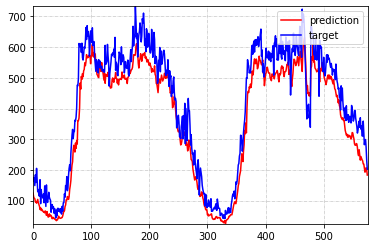

In [5]:
import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # Loading Dataset
    train_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=32)

    test_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=32)

    # Loading Model
    #my_net = GCN(in_c=6, hid_c=6, out_c=1)
    #my_net = ChebNet(in_c=6 * 1, hid_c=6, out_c=1, k=2)
    my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    my_net = my_net.to(device)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=my_net.parameters())

    # Train model
    Epoch = 10

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover

            loss = criterion(predict_value, data["flow_y"])

            epoch_loss += loss.item()

            loss.backward()

            optimizer.step()
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, 1, D]
        Predict = np.zeros_like(Target)  #[N, T, D]

        total_loss = 0.0
        for data in test_loader:

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]

            loss = criterion(predict_value, data["flow_y"])

            total_loss += loss.item()

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "GAT_result.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target


def compute_performance(prediction, target, data):
    try:
        dataset = data.dataset  # dataloader
    except:
        dataset = data  # dataset

    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data


if __name__ == '__main__':
    main()
    visualize_result(h5_file="GAT_result.h5",
                     nodes_id=120,
                     time_se=[0, 24 * 12 * 2],
                     visualize_file="gat_node_120")

In [6]:
import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader





class GCN(nn.Module):
    def __init__(self, in_c, hid_c, out_c):
        super(GCN, self).__init__()
        self.linear_1 = nn.Linear(in_c, hid_c)
        self.linear_2 = nn.Linear(hid_c, out_c)
        self.act = nn.ReLU()

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0]  # [N, N]
        graph_data = GCN.process_graph(graph_data)

        flow_x = data["flow_x"].to(device)  # [B, N, H, D]

        B, N = flow_x.size(0), flow_x.size(1)

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D]  H = 6, D = 1

        output_1 = self.linear_1(flow_x)  # [B, N, hid_C]
        output_1 = self.act(torch.matmul(graph_data, output_1))  # [N, N], [B, N, Hid_C]

        output_2 = self.linear_2(output_1)
        output_2 = self.act(torch.matmul(graph_data, output_2))  # [B, N, 1, Out_C]

        return output_2.unsqueeze(2)

    @staticmethod
    def process_graph(graph_data):
        N = graph_data.size(0)
        matrix_i = torch.eye(N, dtype=graph_data.dtype, device=graph_data.device)
        graph_data += matrix_i  # A~ [N, N]

        degree_matrix = torch.sum(graph_data, dim=-1, keepdim=False)  # [N]
        degree_matrix = degree_matrix.pow(-1)
        degree_matrix[degree_matrix == float("inf")] = 0.  # [N]

        degree_matrix = torch.diag(degree_matrix)  # [N, N]

        return torch.mm(degree_matrix, graph_data)  # D^(-1) * A = \hat(A)


class Baseline(nn.Module):
    def __init__(self, in_c, out_c):
        super(Baseline, self).__init__()
        self.layer = nn.Linear(in_c, out_c)

    def forward(self, data, device):
        flow_x = data["flow_x"].to(device)  # [B, N, H, D]

        B, N = flow_x.size(0), flow_x.size(1)

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D]  H = 6, D = 1

        output = self.layer(flow_x)  # [B, N, Out_C], Out_C = D

        return output.unsqueeze(2)  # [B, N, 1, D=Out_C]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0000, Loss: 0.8611, Time: 0.14 mins
Epoch: 0001, Loss: 0.1801, Time: 0.14 mins
Epoch: 0002, Loss: 0.1441, Time: 0.14 mins
Epoch: 0003, Loss: 0.1418, Time: 0.15 mins
Epoch: 0004, Loss: 0.1408, Time: 0.14 mins
Epoch: 0005, Loss: 0.1398, Time: 0.14 mins
Epoch: 0006, Loss: 0.1387, Time: 0.14 mins
Epoch: 0007, Loss: 0.1376, Time: 0.15 mins
Epoch: 0008, Loss: 0.1365, Time: 0.14 mins
Epoch: 0009, Loss: 0.1354, Time: 0.14 mins
Test Loss: 0.1339
Performance:  MAE 33.70    1.66%    47.76


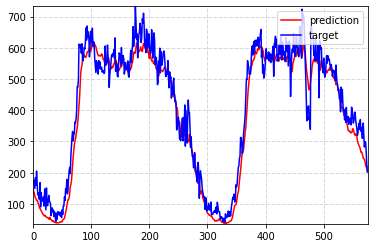

In [7]:
import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # Loading Dataset
    train_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=32)

    test_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=32)

    # Loading Model
    my_net = GCN(in_c=6, hid_c=6, out_c=1)
    #my_net = ChebNet(in_c=6 * 1, hid_c=6, out_c=1, k=2)
    #my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    my_net = my_net.to(device)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=my_net.parameters())

    # Train model
    Epoch = 10

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover

            loss = criterion(predict_value, data["flow_y"])

            epoch_loss += loss.item()

            loss.backward()

            optimizer.step()
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, 1, D]
        Predict = np.zeros_like(Target)  #[N, T, D]

        total_loss = 0.0
        for data in test_loader:

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]

            loss = criterion(predict_value, data["flow_y"])

            total_loss += loss.item()

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "GCN_result.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target


def compute_performance(prediction, target, data):
    try:
        dataset = data.dataset  # dataloader
    except:
        dataset = data  # dataset

    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data


if __name__ == '__main__':
    main()
    visualize_result(h5_file="GCN_result.h5",
                     nodes_id=120,
                     time_se=[0, 24 * 12 * 2],
                     visualize_file="gcn_node_120")

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GraphAttentionLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super(GraphAttentionLayer, self).__init__()
        self.in_c = in_c
        self.out_c = out_c

        self.F = F.softmax

        self.W = nn.Linear(in_c, out_c, bias=False)  # y = W * x
        self.b = nn.Parameter(torch.Tensor(out_c))

        nn.init.normal_(self.W.weight)
        nn.init.normal_(self.b)

    def forward(self, inputs, graph):
        """
        :param inputs: input features, [B, N, C].
        :param graph: graph structure, [N, N].
        :return:
            output features, [B, N, D].
        """

        h = self.W(inputs)  # [B, N, D]
        outputs = torch.bmm(h, h.transpose(1, 2)) * graph.unsqueeze(0)  # [B, N, D]*[B, D, N]->[B, N, N]      x(i)^T * x(j)

        outputs.data.masked_fill_(torch.eq(outputs, 0), -float(1e16))

        attention = self.F(outputs, dim=2)   # [B, N, N]
        return torch.bmm(attention, h) + self.b  # [B, N, N] * [B, N, D]


class GATSubNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATSubNet, self).__init__()

        self.attention_module = nn.ModuleList([GraphAttentionLayer(in_c, hid_c) for _ in range(n_heads)])
        self.out_att = GraphAttentionLayer(hid_c * n_heads, out_c)

        self.act = nn.LeakyReLU()

    def forward(self, inputs, graph):
        """
        :param inputs: [B, N, C]
        :param graph: [N, N]
        :return:
        """
        outputs = torch.cat([attn(inputs, graph) for attn in self.attention_module], dim=-1)  # [B, N, hid_c * h_head]
        outputs = self.act(outputs)

        outputs = self.out_att(outputs, graph)

        return self.act(outputs)


class GATNet(nn.Module):
    def __init__(self, in_c, hid_c, out_c, n_heads):
        super(GATNet, self).__init__()
        self.subnet = GATSubNet(in_c, hid_c, out_c, n_heads)
        # self.subnet = [GATSubNet(...) for _ in range(T)]

    def forward(self, data, device):
        graph = data["graph"][0].to(device)  # [N, N]
        flow = data["flow_x"]  # [B, N, T, C]
        flow = flow.to(device)

        B, N = flow.size(0), flow.size(1)
        flow = flow.view(B, N, -1)  # [B, N, T * C]

        prediction = self.subnet(flow, graph).unsqueeze(2)  # [B, N, 1, C]

        return prediction


if __name__ == '__main__':
    x = torch.randn(32, 278, 6, 2)  # [B, N, T, C]
    graph = torch.randn(32, 278, 278)  # [N, N]
    data = {"flow_x": x, "graph": graph}

    device = torch.device("cpu")

    net = GATNet(in_c=6 * 2, hid_c=6, out_c=2, n_heads=2)

    y = net(data, device)
    print(y.size())

torch.Size([32, 278, 1, 2])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0000, Loss: 2.3774, Time: 0.13 mins
Epoch: 0001, Loss: 1.4027, Time: 0.13 mins
Epoch: 0002, Loss: 0.8028, Time: 0.13 mins
Epoch: 0003, Loss: 0.3895, Time: 0.13 mins
Epoch: 0004, Loss: 0.2720, Time: 0.13 mins
Epoch: 0005, Loss: 0.2337, Time: 0.13 mins
Epoch: 0006, Loss: 0.1946, Time: 0.13 mins
Epoch: 0007, Loss: 0.1781, Time: 0.13 mins
Epoch: 0008, Loss: 0.1695, Time: 0.13 mins
Epoch: 0009, Loss: 0.1632, Time: 0.13 mins
Test Loss: 0.1610
Performance:  MAE 35.52    1.99%    50.49


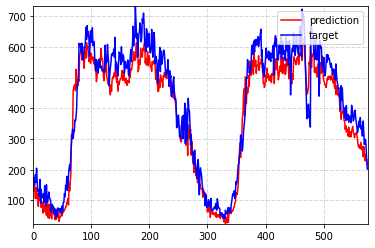

In [9]:
import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # Loading Dataset
    train_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=32)

    test_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=32)

    # Loading Model
    #my_net = GCN(in_c=6, hid_c=6, out_c=1)
    #my_net = ChebNet(in_c=6 * 1, hid_c=6, out_c=1, k=2)
    my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    my_net = my_net.to(device)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=my_net.parameters())

    # Train model
    Epoch = 10

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover

            loss = criterion(predict_value, data["flow_y"])

            epoch_loss += loss.item()

            loss.backward()

            optimizer.step()
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, 1, D]
        Predict = np.zeros_like(Target)  #[N, T, D]

        total_loss = 0.0
        for data in test_loader:

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]

            loss = criterion(predict_value, data["flow_y"])

            total_loss += loss.item()

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "GAT_result.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target


def compute_performance(prediction, target, data):
    try:
        dataset = data.dataset  # dataloader
    except:
        dataset = data  # dataset

    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data


if __name__ == '__main__':
    main()
    visualize_result(h5_file="GAT_result.h5",
                     nodes_id=120,
                     time_se=[0, 24 * 12 * 2],
                     visualize_file="gat_node_120")

In [10]:
class ChebConv(nn.Module):

    def __init__(self, in_c, out_c, K, bias=True, normalize=True):
        """
        ChebNet conv
        :param in_c: input channels
        :param out_c:  output channels
        :param K: the order of Chebyshev Polynomial
        :param bias:  if use bias
        :param normalize:  if use norm
        """
        super(ChebConv, self).__init__()
        self.normalize = normalize

        self.weight = nn.Parameter(torch.Tensor(K + 1, 1, in_c, out_c))  # [K+1, 1, in_c, out_c]
        init.xavier_normal_(self.weight)

        if bias:
            self.bias = nn.Parameter(torch.Tensor(1, 1, out_c))
            init.zeros_(self.bias)
        else:
            self.register_parameter("bias", None)

        self.K = K + 1

    def forward(self, inputs, graph):
        """

        :param inputs: he input data, [B, N, C]
        :param graph: the graph structure, [N, N]
        :return: convolution result, [B, N, D]
        """
        L = ChebConv.get_laplacian(graph, self.normalize)  # [N, N]
        mul_L = self.cheb_polynomial(L).unsqueeze(1)  # [K, 1, N, N]
        result = torch.matmul(mul_L, inputs)  # [K, B, N, C]
        result = torch.matmul(result, self.weight)  # [K, B, N, D]
        result = torch.sum(result, dim=0) + self.bias  # [B, N, D]

        return result

    def cheb_polynomial(self, laplacian):
        """
        Compute the Chebyshev Polynomial, according to the graph laplacian

        :param laplacian: the multi order Chebyshev laplacian, [K, N, N]
        :return:
        """
        N = laplacian.size(0)  # [N, N]
        multi_order_laplacian = torch.zeros([self.K, N, N], device=laplacian.device, dtype=torch.float)  # [K, N, N]
        multi_order_laplacian[0] = torch.eye(N, device=laplacian.device, dtype=torch.float)

        if self.K == 1:
            return multi_order_laplacian
        else:
            multi_order_laplacian[1] = laplacian
            if self.K == 2:
                return multi_order_laplacian
            else:
                for k in range(2, self.K):
                    multi_order_laplacian[k] = 2 * torch.mm(laplacian, multi_order_laplacian[k - 1]) - \
                                               multi_order_laplacian[k - 2]

        return multi_order_laplacian

    @staticmethod
    def get_laplacian(graph, normalize):
        """
        compute the laplacian of the graph
        :param graph: the graph structure without self loop, [N, N]
        :param normalize: whether to used the normalized laplacian
        :return:
        """
        if normalize:
            D = torch.diag(torch.sum(graph, dim=-1) ** (-1 / 2))
            L = torch.eye(graph.size(0), device=graph.device, dtype=graph.dtype) - torch.mm(torch.mm(D, graph), D)
        else:
            D = torch.diag(torch.sum(graph, dim=-1))
            L = D - graph
        return L


class ChebNet(nn.Module):

    def __init__(self, in_c, hid_c, out_c, K):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.
        :param out_c: int, number of output channels.
        :param K:
        """
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(in_c=in_c, out_c=hid_c, K=K)
        self.conv2 = ChebConv(in_c=hid_c, out_c=out_c, K=K)
        self.act = nn.ReLU()

    def forward(self, data, device):
        graph_data = data["graph"].to(device)[0]  # [N, N]
        flow_x = data["flow_x"].to(device)  # [B, N, H, D]

        B, N = flow_x.size(0), flow_x.size(1)

        flow_x = flow_x.view(B, N, -1)  # [B, N, H*D]

        output_1 = self.act(self.conv1(flow_x, graph_data))
        output_2 = self.act(self.conv2(output_1, graph_data))

        return output_2.unsqueeze(2)

In [11]:
import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # Loading Dataset
    train_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=32)

    test_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=32)

    # Loading Model
    #my_net = GCN(in_c=6, hid_c=6, out_c=1)
    my_net = ChebNet(in_c=6 * 1, hid_c=6, out_c=1, k=2)
    #my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)
    #my_net =  ChebNet(in_c=6 * 1, hid_c=6, out_c=1, k=2)
    #my_net = GATSubNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    my_net = my_net.to(device)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=my_net.parameters())

    # Train model
    Epoch = 10

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover

            loss = criterion(predict_value, data["flow_y"])

            epoch_loss += loss.item()

            loss.backward()

            optimizer.step()
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, 1, D]
        Predict = np.zeros_like(Target)  #[N, T, D]

        total_loss = 0.0
        for data in test_loader:

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]

            loss = criterion(predict_value, data["flow_y"])

            total_loss += loss.item()

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "chebnet_result.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target


def compute_performance(prediction, target, data):
    try:
        dataset = data.dataset  # dataloader
    except:
        dataset = data  # dataset

    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data


if __name__ == '__main__':
    main()
    visualize_result(h5_file="chebnet_result.h5",
                     nodes_id=120,
                     time_se=[0, 24 * 12 * 2],
                     visualize_file="gat_node_120")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


TypeError: ignored

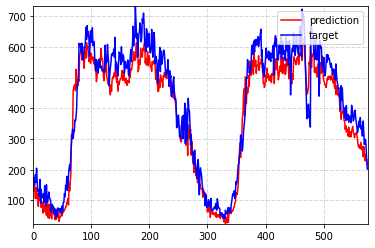

In [12]:


import os
import time
import h5py
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # Loading Dataset
    train_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                          time_interval=5, history_length=6,
                          train_mode="train")

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=32)

    test_data = LoadData(data_path=["/content/sample_data/distance.csv", "/content/sample_data/PEMS04.npz"], num_nodes=307, divide_days=[45, 14],
                         time_interval=5, history_length=6,
                         train_mode="test")

    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=32)

    # Loading Model
    #my_net = GCN(in_c=6, hid_c=6, out_c=1)
    #my_net = ChebNet(in_c=6 * 1, hid_c=6, out_c=1, k=2)
    #my_net = GATNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)
    #my_net = GraphAttentionLayer(in_c=6 * 1, out_c=1)
    my_net = GATSubNet(in_c=6 * 1, hid_c=6, out_c=1, n_heads=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    my_net = my_net.to(device)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(params=my_net.parameters())

    # Train model
    Epoch = 10

    my_net.train()
    for epoch in range(Epoch):
        epoch_loss = 0.0
        start_time = time.time()
        for data in train_loader:  # ["graph": [B, N, N] , "flow_x": [B, N, H, D], "flow_y": [B, N, 1, D]]
            my_net.zero_grad()

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [0, 1] -> recover

            loss = criterion(predict_value, data["flow_y"])

            epoch_loss += loss.item()

            loss.backward()

            optimizer.step()
        end_time = time.time()

        print("Epoch: {:04d}, Loss: {:02.4f}, Time: {:02.2f} mins".format(epoch, 1000 * epoch_loss / len(train_data),
                                                                          (end_time-start_time)/60))

    # Test Model
    my_net.eval()
    with torch.no_grad():
        MAE, MAPE, RMSE = [], [], []
        Target = np.zeros([307, 1, 1]) # [N, 1, D]
        Predict = np.zeros_like(Target)  #[N, T, D]

        total_loss = 0.0
        for data in test_loader:

            predict_value = my_net(data, device).to(torch.device("cpu"))  # [B, N, 1, D]  -> [1, N, B(T), D]

            loss = criterion(predict_value, data["flow_y"])

            total_loss += loss.item()

            predict_value = predict_value.transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]
            target_value = data["flow_y"].transpose(0, 2).squeeze(0)  # [1, N, B(T), D] -> [N, B(T), D] -> [N, T, D]

            performance, data_to_save = compute_performance(predict_value, target_value, test_loader)

            Predict = np.concatenate([Predict, data_to_save[0]], axis=1)
            Target = np.concatenate([Target, data_to_save[1]], axis=1)

            MAE.append(performance[0])
            MAPE.append(performance[1])
            RMSE.append(performance[2])

        print("Test Loss: {:02.4f}".format(1000 * total_loss / len(test_data)))

    print("Performance:  MAE {:2.2f}    {:2.2f}%    {:2.2f}".format(np.mean(MAE), np.mean(MAPE * 100), np.mean(RMSE)))

    Predict = np.delete(Predict, 0, axis=1)
    Target = np.delete(Target, 0, axis=1)

    result_file = "GAT_result.h5"
    file_obj = h5py.File(result_file, "w")

    file_obj["predict"] = Predict
    file_obj["target"] = Target


def compute_performance(prediction, target, data):
    try:
        dataset = data.dataset  # dataloader
    except:
        dataset = data  # dataset

    prediction = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], prediction.numpy())
    target = LoadData.recover_data(dataset.flow_norm[0], dataset.flow_norm[1], target.numpy())

    mae, mape, rmse = Evaluation.total(target.reshape(-1), prediction.reshape(-1))

    performance = [mae, mape, rmse]
    recovered_data = [prediction, target]

    return performance, recovered_data


if __name__ == '__main__':
    #main()
    visualize_result(h5_file="GAT_result.h5",
                     nodes_id=120,
                     time_se=[0, 24 * 12 * 2],
                     visualize_file="gat_node_120")

 
 